In [2]:
# load usual python packages
import numpy as np
import scipy as sp
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import time
import math
from scipy.optimize import curve_fit

#for reading binary files
import struct 
from struct import *


# for reading and displaying images
#from skimage.io import imread
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Getting parameters and Loading output files

First we need to extract the values of the required input parameters: _nDepthLayers_ and _nYears_. Those can be found in "SLAMS2.0_modelfiles/namelist.input". **CHANGE VALUES IF THE INPUTS HAVE BEEN CHANGED**

In [3]:
nDepthLayers = 387
nYears = 20

Now looking at the output files and their description:

| File name  | Dimensions    | Precision         | Units | Content   |
| :--------- | :-----------: | :---------: | :---: | :---------|
| out_control.bin | [8 x 1] | int32 | na | Records 8 simulation outputs: (1= \# time steps past, 2=last position in particle array occupied, 3=nTimesFlux,4=nSedTrapDeployDepths, 5=nImagingDeployDepths, 6=nTimesAvgAtt, 7=nTimesStats, 8=nTimesAux) |
|  out_stats_nClusters.bin  | [nTimesStats x 1] | int32 | na | after a certain period of every modelled year (i.e., nTimesStats), record the number of extant clusters |
| out_stats_nParticles.bin    | [nTimesStats x 1] | float64 | na | after a certain period of every modelled year (i.e., nTimesStats), record the number of extant particles	|
| out_flux_seafloor.bin | [6 x 1 x nTimesFlux] | float64 | $\textrm{mg } \textrm{m}^{-2} \textrm{ d}^{-1}$ | every month of every modelled year (i.e., nTimesFlux), record the fluxes at seafloor of 6 materials (1=organic carbon, 2=TEP carbon, 3=calcite, 4=aragonite, 5=opal, 6=clay) |
| out_flux.bin | [6 x nSedTrapDeployDepths x nTimesFlux] | float64 | $\textrm{mg } \textrm{m}^{-2} \textrm{ d}^{-1}$ | every month of every modelled year (i.e., nTimesFlux), record at every sediment trap deployment depth (nSedTrapDeployDepths) the fluxes of 6 materials (as before). **Check subroutine GetDepthsForParticleDataCollection in file modelparameters.F90 for the deployment depth values**|
| out_avgparticleatt_maintype_seafloor.bin | [nMainParticleTypes x 1 x 7 x nTimesAvgAtt] | float64 | na | every month of every modelled year  (i.e., nTimesAvgAtt), record 7 average particle attributes (do not look at 1-3, only 4=radius, 5=density, 6=velocity, 7=porosity) for all the particles that have reached seafloor classified according to the particle main type (nMainParticleTypes). **Check file pstruct.h for the units of the attributes. Check function ParticleType in file modeloutput.F90 for the particle types** |
| out_avgparticleatt_maintype.bin | [nMainParticleTypes x nImagingDeployDepths x 7 x nTimesAvgAtt] | float64 | na | every month of every modelled year  (i.e., nTimesAvgAtt), record 7 average particle attributes (do not look at 1-3, only 4=radius, 5=density, 6=velocity, 7=porosity) for all the particles that have crossed specific depths where imaging systems are placed (nImagingDeployDepths) classified according to the particle main type (nMainParticleTypes). **Check file pstruct.h for the units of the attributes. Check function ParticleType in file modeloutput.F90 for the particle types. Check subroutine GetDepthsForParticleDataCollection in file modelparameters.F90 for the imaging deployment depth values** |
| out_avgparticleatt_sizeclass_seafloor.bin | [nSizeClasses x 1 x 15 x nTimesAvgAtt] | float64 | na | every month of every modelled year (i.e., nTimesAvgAtt), record 15 average particle attributes (1=number of particles, 2=density, 3=velocity, 4=stickiness, 5=porosity, 6=solid volume, 7=fractal dimension, 8=radius primary particle, 9=depth, 10=mol organic carbon, 11=mol TEP-C, 12=mol opal, 13=mol calcite, 14=mol aragonite, 15=mol clay) for all the particles that have reached seafloor classified according to the particle size class (nSizeClasses). **Check file pstruct.h for the units of the attributes. Check Section 5 in file modelparameters.F90 for the particle size classes**|
| out_avgparticleatt_sizeclass.bin | [nSizeClasses x nImagingDeployDepths x 15 x nTimesAvgAtt] | float64 | na | every month of every modelled year (i.e., nTimesAvgAtt), record 15 average particle attributes (as before, only that 1=number of particles per litre) for all the particles that have crossed specific depths where imaging systems are placed (nImagingDeployDepths) classified according to the particle size class (nSizeClasses). **Check file pstruct.h for the units of the attributes. Check Section 5 in file modelparameters.F90 for the particle size classes. Check subroutine GetDepthsForParticleDataCollection in file modelparameters.F90 for the imaging deployment depth values**|
| out_avgparticleatt_veloclass_seafloor.bin | [nVeloClasses x 1 x 15 x nTimesAvgAtt] | float64 | na | every month of every modelled year (i.e., nTimesAvgAtt), record 15 average particle attributes (as before, only that 1=number of particles, 3=radius) for all the particles that have reached seafloor classified according to the particle velocity class (nVeloClasses). **Check file pstruct.h for the units of the attributes. Check Section 5 in file modelparameters.F90 for the particle velocity classes**|
| out_avgparticleatt_veloclass.bin | [nVeloClasses x nImagingDeployDepths x 15 x nTimesAvgAtt] | float64 | na | every month of every modelled year (i.e., nTimesAvgAtt), record 15 average particle attributes (as before, only that 1=number of particles per litre, 3=radius) for all the particles that have crossed specific depths where imaging systems are placed (nImagingDeployDepths) classified according to the particle velocity class (nVeloClasses). **Check file pstruct.h for the units of the attributes. Check Section 5 in file modelparameters.F90 for the particle velocity classes. Check subroutine GetDepthsForParticleDataCollection in file modelparameters.F90 for the imaging deployment depth values**|
| out_sms.bin | [maxNumSmsTerms x nDepthLayers x nTimesAux] | float64 | $\textrm{mol}$ | every month of every modelled year (i.e., nTimesAux), record at every modelled depth layer (nDepthLayers) the sources-minus-sinks (SMS) terms (maxNumSmsTerms). **Check Section 3 in file modelparameters.F90 for the SMS terms**|
| out_sms_annual.bin | [maxNumSmsTerms x nYears] | float64 |  $\textrm{mol } \textrm{m}^{-2} \textrm{ yr}^{-1}$ |  at the end of every modelled year (i.e., nYears), record a water column average of the sources-minus-sinks (SMS) terms (maxNumSmsTerms). **Check Section 3 in file modelparameters.F90 for the SMS terms**|
| out_aux.bin | [maxNumAuxTerms x nDepthLayers x nTimesAux] | float64 | na | every month of every modelled year (i.e., nTimesAux), record at every modelled depth layer (nDepthLayers) the auxiliary terms (maxNumAuxTerms). **Check Section 4 in file modelparameters.F90 for the auxiliary terms and their units** |
| out_cluster_i.bin | [maxNumClusters x 6 x 3] | int32 | na | during the last modelled year, after each four months (i.e., 3 times a year), record the 6 particle attributes that are integer values for all clusters (maxNumClusters) **Check file pstruct.h for the attributes (integer) and their units**|
| out_cluster_r.bin | [maxNumClusters x 20 x 3] | float64 | na |during the last modelled year, after each four months (i.e., 3 times a year), record the 20 particle attributes that are real values for all clusters (maxNumClusters). **Check file pstruct.h for the attributes (real\*8) and their units** |




In [4]:
#setting path to output files 
file_path = "SLAMS2.0_outputs/20_years/"

#loading output files 
out_control = np.fromfile(file_path + "out_control.bin", dtype='>i4')
nTimeStepsPassed, lastpos, nTimesFlux, nSedTrapDeployDepth, nImagingDeployDepth,\
nTimesAvgAtt, nTimesStats, nTimesAux = out_control

out_stats_nClusters = np.fromfile(file_path + "out_stats_nClusters.bin",dtype='>i4')
out_stats_nParticles = np.fromfile(file_path + "out_stats_nParticles.bin", dtype='>f8')


out_flux_seafloor = np.fromfile(file_path + "out_flux_seafloor.bin", dtype='>f8').reshape(6,1,nTimesFlux)

out_flux = np.fromfile(file_path + "out_flux.bin",dtype='>f8').reshape(6,nSedTrapDeployDepth,nTimesFlux)

#getting the nMainParticleTypes and the correct shape of out_avgparticleatt_maintype_seafloor
out_avgparticleatt_maintype_seafloor_ = np.fromfile(file_path + "out_avgparticleatt_maintype_seafloor.bin",
                                                  dtype='>f8')
nMainParticleTypes = int(len(out_avgparticleatt_maintype_seafloor_)/(7*nTimesAvgAtt))
out_avgparticleatt_maintype_seafloor = out_avgparticleatt_maintype_seafloor_.reshape(nMainParticleTypes,
                                                                                    7,nTimesAvgAtt)

out_avgparticleatt_maintype = np.fromfile(file_path + "out_avgparticleatt_maintype.bin",
                                          dtype='>f8').reshape(nMainParticleTypes,nImagingDeployDepth,
                                                               7,nTimesAvgAtt)

#getting the nSizeClasses and the correct shape of out_avgparticleatt_sizeclass_seafloor 
out_avgparticleatt_sizeclass_seafloor_ = np.fromfile(file_path + "out_avgparticleatt_sizeclass_seafloor.bin",
                                                  dtype='>f8')
nSizeClasses = int(len(out_avgparticleatt_sizeclass_seafloor_)/(15*nTimesAvgAtt))
out_avgparticleatt_sizeclass_seafloor = out_avgparticleatt_sizeclass_seafloor_.reshape(nSizeClasses,
                                                                                       15,nTimesAvgAtt)


out_avgparticleatt_sizeclass = np.fromfile(file_path + "out_avgparticleatt_sizeclass.bin",
                                           dtype='>f8').reshape(nSizeClasses, nImagingDeployDepth,
                                                                15,nTimesAvgAtt)

#getting the nVeloClasses and the correct shape of out_avgparticleatt_veloclass_seafloor
out_avgparticleatt_veloclass_seafloor_ = np.fromfile(file_path + "out_avgparticleatt_veloclass_seafloor.bin",
                                                  dtype='>f8')
nVeloClasses = int(len(out_avgparticleatt_veloclass_seafloor_)/(15*nTimesAvgAtt))
out_avgparticleatt_veloclass_seafloor = out_avgparticleatt_veloclass_seafloor_.reshape(nVeloClasses,
                                                                                       15,nTimesAvgAtt)

out_avgparticleatt_veloclass = np.fromfile(file_path + "out_avgparticleatt_veloclass.bin",
                                           dtype='>f8').reshape(nVeloClasses, nImagingDeployDepth,
                                                                15,nTimesAvgAtt)
#getting the maxNumSmsTerms and the correct shape of out_sms
out_sms_ = np.fromfile(file_path + "out_sms.bin", dtype='>f8')
maxNumSmsTerms = int(len(out_sms_)/(nDepthLayers*nTimesAux))
out_sms = out_sms_.reshape(maxNumSmsTerms,nDepthLayers,nTimesAux)

out_sms_annual = np.fromfile(file_path + "out_sms_annual.bin", dtype='>f8').reshape(maxNumSmsTerms, nYears)

#getting the maxNumAuxTerms and the correct shape of out_aux
out_aux_ = np.fromfile(file_path + "out_aux.bin", dtype='>f8')
maxNumAuxTerms = int(len(out_aux_)/(nDepthLayers*nTimesAux))
out_aux = out_aux_.reshape(maxNumAuxTerms,nDepthLayers,nTimesAux)

#getting the maxNumClusters_i and the correct shape of out_cluster_i
out_cluster_i_ = np.fromfile(file_path + "out_cluster_i.bin", dtype='>i4')
maxNumClusters_i = int(len(out_cluster_i_)/(6*3))
out_cluster_i = out_cluster_i_.reshape(maxNumClusters_i,6,3)

#getting the maxNumClusters_r and the correct shape of out_cluster_r
out_cluster_r_ = np.fromfile(file_path + "out_cluster_i.bin", dtype='>f8')
maxNumClusters_r = int(len(out_cluster_r_)/(20*3))
out_cluster_r = out_cluster_r_.reshape(maxNumClusters_r,20,3) 

print("Input Model Parameters: \nnDepthLayers = {}, \nnYears = {},"
      " \nNumber of Time Steps Passed = {}, \nnTimesFlux = {}, \nnSedTrapDeployDepth = {},"
      "\nnImagingDeployDepths = {}, \nnTimesAvgAtt = {}, \nnTimesStats = {}, \nnTimesAux = {},"
      " \nnMainParticleTypes = {}, \nnSizeClasses = {}, \nnVeloClasses = {}, \nmaxNumSmsTerms = {},"
      " \nmaxNumAuxTerms = {}, \nmaxNumClusters_i = {}, \nmaxNumClusters_r = {}".format(
nDepthLayers,nYears,nTimeStepsPassed,nTimesFlux,nSedTrapDeployDepth,nImagingDeployDepth,
    nTimesAvgAtt,nTimesStats,nTimesAux,nMainParticleTypes,nSizeClasses, nVeloClasses,
    maxNumSmsTerms,maxNumAuxTerms, maxNumClusters_i,maxNumClusters_r))

Input Model Parameters: 
nDepthLayers = 387, 
nYears = 20, 
Number of Time Steps Passed = 21900, 
nTimesFlux = 240, 
nSedTrapDeployDepth = 30,
nImagingDeployDepths = 30, 
nTimesAvgAtt = 240, 
nTimesStats = 240, 
nTimesAux = 240, 
nMainParticleTypes = 8, 
nSizeClasses = 15, 
nVeloClasses = 17, 
maxNumSmsTerms = 45, 
maxNumAuxTerms = 30, 
maxNumClusters_i = 500000, 
maxNumClusters_r = 75000


## Turning the Data into managable format for Analysis and ML

We need to combine as many files as possible into managable Dataset. So far there are too many files and it is hard to do any sort of analysis on the data with that many files. We start by converting the Data into pandas DataFrames and trying to  flatten out the dimensions.

In [5]:
#defining extra features (e.g. the month and the type of particle) (not required)
month_labeling = []
for i in range(1,13):
    month_labeling.append([i]*nMainParticleTypes)
    
if nYears > 1:
    month_labeling = month_labeling*nYears
    
month_labeling = np.array(month_labeling).reshape(nMainParticleTypes*12*nYears)
particle_type = list(np.arange(1,nMainParticleTypes+1))*12*nYears

depth_labeling = []
for i in range(10,100,10):
    depth_labeling.append(i)
for i in range(100,1100,100):
    depth_labeling.append(i)
for i in range(1250,4250,250):
    depth_labeling.append(i)
for i in range(4500,10500,500):
    depth_labeling.append(i)

#convert the out_avgparticleatt_maintype_seafloor.bin into DataFrame for better data visualisation 
# to turn into DataFrame need to make binary file output compatible with pandas structures
# need to also transpose the array in order to make time dimensions to be the first one 
# and drop the first 3 average particle attributes 
avgparticleatt_maintype_seafloor = pd.DataFrame(np.transpose(
    out_avgparticleatt_maintype_seafloor.byteswap().newbyteorder(),(2,0,1)).reshape(
    nMainParticleTypes*12*nYears,7)).iloc[:,3:]

#naming the attributes and adding the depth, month and type label
avgparticleatt_maintype_seafloor.columns = ['radius', 'density', 'velocity', 'porosity']
avgparticleatt_maintype_seafloor['month'] = list(month_labeling)
avgparticleatt_maintype_seafloor['type'] = particle_type
avgparticleatt_maintype_seafloor['depth_reached'] = [
    depth_labeling[int(nImagingDeployDepth)]]*len(avgparticleatt_maintype_seafloor)

#flattening the out_avgparticleatt_maintype.bin into 2D DataFrame
depth_labeling_many_depth = []
for i in depth_labeling:
    depth_labeling_many_depth.append([i]*nMainParticleTypes*12*nYears)

all_depths = np.array(depth_labeling_many_depth)[:nImagingDeployDepth,:].reshape(
    nImagingDeployDepth*nMainParticleTypes*12*nYears)
all_month = list(month_labeling)*nImagingDeployDepth
all_types = list(particle_type)*nImagingDeployDepth

#naming the attributes and adding the depth, month and type label
time_transposed_reshaped = np.transpose(
    out_avgparticleatt_maintype.byteswap().newbyteorder(), (3,0,1,2)).reshape(
    nTimesAvgAtt*nMainParticleTypes,nImagingDeployDepth,7)

avgparticleatt_maintype = pd.DataFrame(np.transpose(
    time_transposed_reshaped, (1,0,2)).reshape(nImagingDeployDepth*nMainParticleTypes*12*nYears,7)).iloc[:,3:]
avgparticleatt_maintype.columns = ['radius', 'density', 'velocity', 'porosity']
avgparticleatt_maintype['type'] = all_types
avgparticleatt_maintype['month'] = all_month
avgparticleatt_maintype['depth_reached'] = all_depths

avgparticleatt_maintype_all = pd.concat((avgparticleatt_maintype,
                                         avgparticleatt_maintype_seafloor)).reset_index(drop=True)
avgparticleatt_maintype_all

,radius,density,velocity,porosity,type,month,depth_reached
0,6.414371e+00,1.056524e+00,-1.474603,0.419362,1,1,10
1,2.949789e+00,9.477490e-01,-0.290708,0.408328,2,1,10
2,3.101292e+00,9.513754e-01,-0.328917,0.411347,3,1,10
3,3.201147e+00,9.454200e-01,-0.357865,0.411913,4,1,10
4,3.190974e+00,9.464767e-01,-0.346948,0.411832,5,1,10
...,...,...,...,...,...,...,...
59515,1.197973e+08,1.107349e-21,2.712372,0.000000,4,12,4000
59516,4.206832e+08,1.107349e-21,2.743678,0.000000,5,12,4000
59517,5.756490e+08,1.107349e-21,2.736886,0.000000,6,12,4000
59518,7.453079e+08,1.107354e-21,2.741525,0.000000,7,12,4000


In [20]:
# combining sizeclass files 
#list of 15 attrinutes in the output file
fifteen_atributes = ['#_of_particles', 'density', 'velocity', 'stikiness', 'porosity',
                                            'solid_volume','fractial_dimensions', 'radius_primary_particle',
                                            'depth','mol_organic_carbon','mol_TEPC','mol_opal','nol_calcite',
                                            'mol_aragonite', 'mol_clay']

sizeclass_sizes = [1, 2, 4, 8, 16, 32, 64,128,256,512,1024,2048,4096,8192,16384]
sizeclasses_for_hist = [1,10,100,1000,10000]

month_labeling_sizeclasses = []
for i in range(1,13):
    month_labeling_sizeclasses.append([i]*nSizeClasses)
    
season_labeling_sizeclasses = []
for i in range(1,5):
    season_labeling_sizeclasses.append([i]*3*nSizeClasses)

season_label = np.array(season_labeling_sizeclasses).reshape(12*nSizeClasses)   
month_labeling_sizeclasses = np.array(month_labeling_sizeclasses).reshape(nSizeClasses*12)

sizeclass_type = list(np.arange(1,nSizeClasses+1))*12

    
avgparticleatt_sizeclass_seafloor = pd.DataFrame(
    np.transpose(out_avgparticleatt_sizeclass_seafloor[:,:,-12:].reshape(
        nSizeClasses,15,12).byteswap().newbyteorder(),(2,0,1)).reshape(nSizeClasses*12,15))

avgparticleatt_sizeclass_seafloor.columns = fifteen_atributes

avgparticleatt_sizeclass_seafloor['month'] = month_labeling_sizeclasses
avgparticleatt_sizeclass_seafloor['type'] = sizeclass_type
avgparticleatt_sizeclass_seafloor['depth_reached'] = [
    depth_labeling[int(nImagingDeployDepth)]]*len(avgparticleatt_sizeclass_seafloor)
avgparticleatt_sizeclass_seafloor['season'] = season_label

#flattening the out_avgparticleatt_maintype.bin into 2D DataFrame
depth_labeling_many_depth_sizeclass = []
for i in depth_labeling:
    depth_labeling_many_depth_sizeclass.append([i]*nSizeClasses*12)

all_depths_sizeclass = np.array(depth_labeling_many_depth_sizeclass)[:nImagingDeployDepth,:].reshape(
    nImagingDeployDepth*nSizeClasses*12)

all_month_sizeclass = list(month_labeling_sizeclasses)*nImagingDeployDepth
all_types_sizeclass = list(sizeclass_type)*nImagingDeployDepth
all_seasons_sizeclass = list(season_label)*nImagingDeployDepth

#naming the attributes and adding the depth, month and type label
time_transposed_reshaped = np.transpose(
    out_avgparticleatt_sizeclass[:,:,:,-12:].byteswap().newbyteorder(), (3,0,1,2)).reshape(
    12*nSizeClasses,nImagingDeployDepth,15)

avgparticleatt_sizeclass = pd.DataFrame(np.transpose(
    time_transposed_reshaped, (1,0,2)).reshape(nImagingDeployDepth*nSizeClasses*12,15))
avgparticleatt_sizeclass.columns = fifteen_atributes
avgparticleatt_sizeclass['type'] = all_types_sizeclass
avgparticleatt_sizeclass['month'] = all_month_sizeclass
avgparticleatt_sizeclass['depth_reached'] = all_depths_sizeclass
avgparticleatt_sizeclass['season'] = all_seasons_sizeclass

avgparticleatt_sizeclass_all = pd.concat(
    (avgparticleatt_sizeclass, avgparticleatt_sizeclass_seafloor)).reset_index(drop=True)

avgparticleatt_sizeclass_all

,#_of_particles,density,velocity,stikiness,porosity,solid_volume,fractial_dimensions,radius_primary_particle,depth,mol_organic_carbon,mol_TEPC,mol_opal,nol_calcite,mol_aragonite,mol_clay,type,month,depth_reached,season
0,4.048710,2.124945,1.046766,1.918486,0.036674,0.000000e+00,2.761829e-04,0.000000e+00,0.400034,1.595761e+02,151.293289,2.872871e+00,2.000000,2.322622e+00,2.352357,1,1,10,1
1,64088.744996,2.141694,2.837896,2.011023,2.281902,1.998395e-09,2.057536e-03,7.539044e-03,0.570022,1.103171e+02,57.632209,2.950996e+00,2.000007,2.631910e+00,1.007476,2,1,10,1
2,41091.503219,2.080707,2.848019,2.600805,1.775342,4.858492e-09,7.667100e-07,1.025212e-04,0.043159,1.188169e+02,164.503903,2.999057e+00,2.436541,2.848356e+00,1.109947,3,1,10,1
3,37915.187779,2.146718,2.859380,1.916862,1.615575,8.521727e-05,8.281369e-05,7.175383e-04,0.017200,8.787575e+01,138.405831,2.996636e+00,2.963024,2.816158e+00,3.433553,4,1,10,1
4,53844.804572,2.158941,2.849547,2.090320,1.686562,4.390890e-10,1.773705e-06,5.408179e-08,0.006687,1.107019e+02,93.746985,2.983994e+00,2.969757,2.725577e+00,3.162257,5,1,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,5.892739e-07,0.000000,3.752409e-07,0.000000,2.070689e-10,0.000000,11,12,4000,4
5576,0.000000,1.027847,0.000000,0.000000,0.000000,2.305764e+08,0.000000e+00,0.000000e+00,0.000000,3.247603e-07,0.000000,0.000000e+00,0.000007,0.000000e+00,0.000000,12,12,4000,4
5577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,3870.000000,0.000000e+00,0.000000,0.000000e+00,0.000004,0.000000e+00,0.000000,13,12,4000,4
5578,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,4.016155e-08,0.000000,0.000000e+00,0.000000,14,12,4000,4


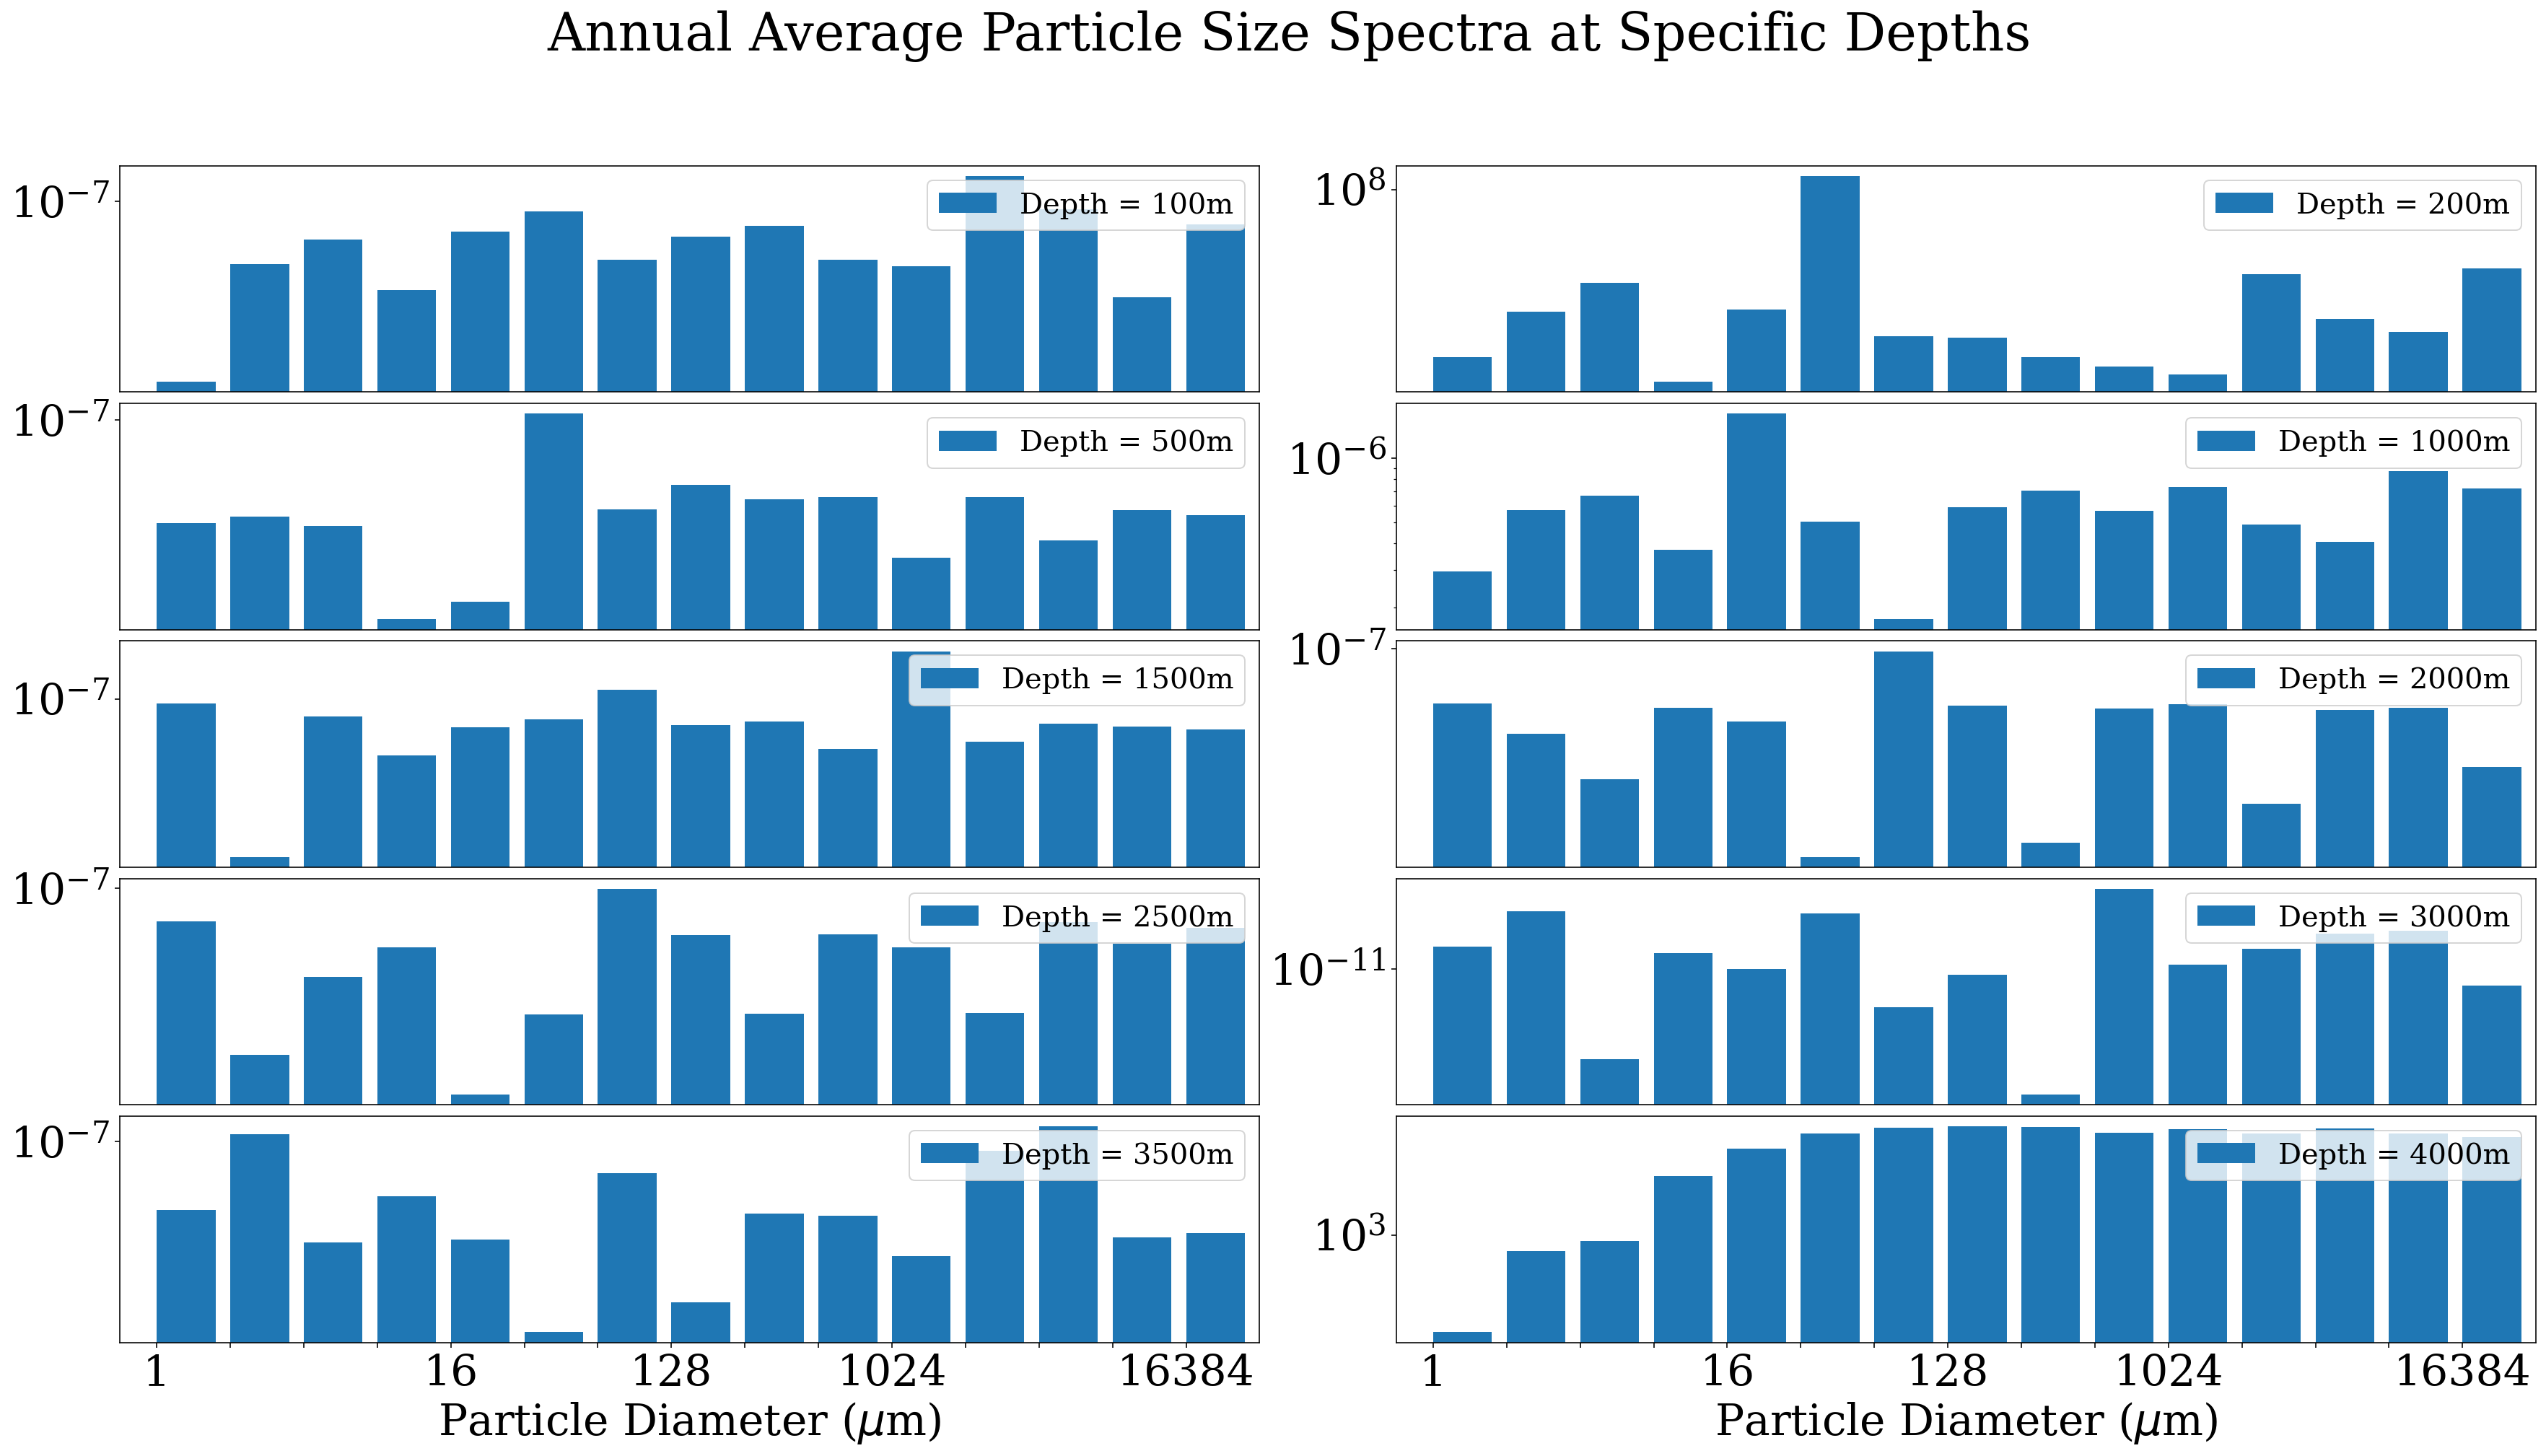

In [16]:
#seasonal average of the particle sizes
array_of_depth = [100,200,500,1000,1500,2000,2500,3000,3500,4000]

#setting the plotting parameters
params = {
    'image.cmap': 'gray',
    'axes.labelsize': 30, # fontsize for x and y labels (was 10)
    'axes.titlesize': 30,
    'font.size': 30, # was 10
    'legend.fontsize': 20, # was 10
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.figsize': [30, 15],
    'font.family': 'serif',
}

#updating parameters for plotting
matplotlib.rcParams.update(params)

#setting up the graph structure
fig = plt.figure()
fig.suptitle("Annual Average Particle Size Spectra at Specific Depths") 
gs = matplotlib.gridspec.GridSpec(5, 2, width_ratios=[1.,1.], height_ratios=[1.,1.,1.,1.,1.])
gs.update(wspace=0.12, hspace=0.05)
 
#calculating and plotting the annual average particle size distribution 
#looping through every depth
for j in range(len(array_of_depth)):
    #data of all sizeclasses at one specific depth
    sep_depth = avgparticleatt_sizeclass_all[avgparticleatt_sizeclass_all['depth_reached']
                                 == array_of_depth[j]][['#_of_particles','type','month','season']]
    #loop through all sizeclasses
    for i in range(1,16):
        #we need to create one DataFrame for the first sizeclass and then add on data for all other sizeclasses
        if i == 1:
            #separating one particle sizeclass
            one_type_on_sep_depth = sep_depth[sep_depth['type'] == i][['#_of_particles','season']]
            # calculating the seasonal mean
            one_type_one_depth_mean = one_type_on_sep_depth.groupby('season').mean().reset_index()
            #recording the sizeclass
            one_type_one_depth_mean['size_class'] = i
            #recording th depth
            one_type_one_depth_mean['depth'] = array_of_depth[j]
        else:
            # doing the same for every other sizeclass
            other_one_type_on_sep_depth = sep_depth[sep_depth['type'] == i][['#_of_particles','season']]
            other_one_type_one_depth_mean = other_one_type_on_sep_depth.groupby('season').mean().reset_index()
            other_one_type_one_depth_mean['size_class'] = i
            other_one_type_one_depth_mean['depth'] = array_of_depth[j]
            
            #combining the data for different size classes together
            one_type_one_depth_mean = pd.concat((one_type_one_depth_mean,
                                                 other_one_type_one_depth_mean)).reset_index(drop=True)
            
    #separating only the required features (columns) 
    all_types_one_depth = one_type_one_depth_mean[['season','#_of_particles','size_class','depth']]
    
    #calculating the annual average for every size class 
    annual_average = sep_depth[['type','#_of_particles']].groupby(by='type').mean().reset_index()

    
    #plotting the annual particle size distribution 
    ax1 = fig.add_subplot(gs[j])
    ax1.bar(annual_average['type'], annual_average['#_of_particles'],log=True,
            label='Depth = ' +str(array_of_depth[j]) +'m',align='edge')

    if j<=7: #drops all x labels for top subplots
        ax1.tick_params(top=False, bottom=False, labelleft='on', labelbottom=False)

    if j>7: # labeling the x axis on the bottom two subplots
        ax1.tick_params(bottom=True, labelleft='on', labelbottom=True)

        ax1.set_xticks(annual_average['type'] )
        ax1.set_xticklabels(['1','','', '', '16', '', '','128','','','1024','','','','16384'])
        ax1.set_xlabel(r'Particle Diameter ($\mu$m)')

        
    ax1.set_xlim(0.5,16)
    ax1.legend(loc='upper right')

#saves the figure    
#plt.savefig("Annual_Average_Particle_Size_Spectra_at_Specific_Depth.png")
plt.show()


In [19]:
# combining veloclasses files together into 2D DataFrame 
#list of 15 attrinutes
fifteen_atributes = ['#_of_particles', 'density', 'velocity', 'stikiness', 'porosity',
                                            'solid_volume','fractial_dimensions', 'radius_primary_particle',
                                            'depth','mol_organic_carbon','mol_TEPC','mol_opal','nol_calcite',
                                            'mol_aragonite', 'mol_clay']

veloclasses_velocity = [1,1.8,3.2,5.6,10,17.8,31.6,56.2,100,177.8,316.2,562.3,1000,1778.3,3162.3,5623.4,10000]
#sizeclasses_for_hist = [1,10,100,1000,10000]

month_labeling_veloclasses = []
for i in range(1,13):
    month_labeling_veloclasses.append([i]*nVeloClasses)
    
season_labeling_veloclasses = []
for i in range(1,5):
    season_labeling_veloclasses.append([i]*3*nVeloClasses)

season_label_veloclasses = np.array(season_labeling_veloclasses).reshape(12*nVeloClasses)   
month_labeling_veloclasses = np.array(month_labeling_veloclasses).reshape(nVeloClasses*12)

veloclasses_type = list(np.arange(1,nVeloClasses+1))*12

    
avgparticleatt_veloclass_seafloor = pd.DataFrame(
    np.transpose(out_avgparticleatt_veloclass_seafloor[:,:,-12:].reshape(
        nVeloClasses,15,12).byteswap().newbyteorder(),(2,0,1)).reshape(nVeloClasses*12,15))

avgparticleatt_veloclass_seafloor.columns = fifteen_atributes

avgparticleatt_veloclass_seafloor['month'] = month_labeling_veloclasses
avgparticleatt_veloclass_seafloor['type'] = veloclasses_type
avgparticleatt_veloclass_seafloor['depth_reached'] = [
    depth_labeling[int(nImagingDeployDepth)]]*len(avgparticleatt_veloclass_seafloor)
avgparticleatt_veloclass_seafloor['season'] = season_label_veloclasses

#flattening the out_avgparticleatt_maintype.bin into 2D DataFrame
depth_labeling_many_depth_veloclasses = []
for i in depth_labeling:
    depth_labeling_many_depth_veloclasses.append([i]*nVeloClasses*12)

all_depths_veloclass = np.array(depth_labeling_many_depth_veloclasses)[:nImagingDeployDepth,:].reshape(
    nImagingDeployDepth*nVeloClasses*12)

all_month_veloclasses = list(month_labeling_veloclasses)*nImagingDeployDepth
all_types_veloclasses = list(veloclasses_type)*nImagingDeployDepth
all_seasons_veloclasses = list(season_label_veloclasses)*nImagingDeployDepth

#naming the attributes and adding the depth, month and type label
time_transposed_reshaped_vel = np.transpose(
    out_avgparticleatt_veloclass[:,:,:,-12:].byteswap().newbyteorder(), (3,0,1,2)).reshape(
    12*nVeloClasses,nImagingDeployDepth,15)

avgparticleatt_veloclass = pd.DataFrame(np.transpose(
    time_transposed_reshaped_vel, (1,0,2)).reshape(nImagingDeployDepth*nVeloClasses*12,15))
avgparticleatt_veloclass.columns = fifteen_atributes
avgparticleatt_veloclass['type'] = all_types_veloclasses
avgparticleatt_veloclass['month'] = all_month_veloclasses
avgparticleatt_veloclass['depth_reached'] = all_depths_veloclass
avgparticleatt_veloclass['season'] = all_seasons_veloclasses

# final DataFrame with all information from out_avgparticleatt_veloclass_seafloor.bin 
# and out_avgparticleatt_veloclass.bin
avgparticleatt_veloclass_all = pd.concat(
    (avgparticleatt_veloclass, avgparticleatt_veloclass_seafloor)).reset_index(drop=True)

#prints the DataFrame
avgparticleatt_veloclass_all



,#_of_particles,density,velocity,stikiness,porosity,solid_volume,fractial_dimensions,radius_primary_particle,depth,mol_organic_carbon,mol_TEPC,mol_opal,nol_calcite,mol_aragonite,mol_clay,type,month,depth_reached,season
0,8.493978e-02,2.365860e-03,1.742702e+00,1.258621e+00,0.000000e+00,3.918451e+00,1.349886e-09,0.000000e+00,4.829519e-01,5.449093e-01,0.000000e+00,3.564541e+07,0.000000e+00,0.000000e+00,2.928946e+00,1,1,10,1
1,3.627236e+01,8.527001e+01,0.000000e+00,3.822250e-04,0.000000e+00,0.000000e+00,1.342269e+02,1.954332e+02,1.374649e+04,2.003271e+00,2.002240e+00,9.069080e+01,1.144866e+02,0.000000e+00,2.376819e+03,2,1,10,1
2,1.028467e-01,5.174505e-01,7.420259e-01,1.539087e+07,2.130638e+07,0.000000e+00,2.000001e+00,2.648595e+00,2.329713e+00,6.452620e+01,1.383236e+03,0.000000e+00,2.195272e-07,0.000000e+00,0.000000e+00,3,1,10,1
3,2.442859e+03,2.002726e+00,2.003086e+00,0.000000e+00,8.013605e+01,0.000000e+00,0.000000e+00,1.075194e-10,7.781478e-14,2.360186e-10,2.315356e-11,4.595833e-10,1.420193e-09,2.836730e-07,0.000000e+00,4,1,10,1
4,3.634271e+00,5.172061e+00,4.510256e+02,3.125725e+03,3.045150e-07,2.106542e-07,0.000000e+00,2.302057e-16,8.795955e-15,2.225166e-12,3.771203e-11,7.127362e-10,0.000000e+00,1.042610e-51,0.000000e+00,5,1,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6319,2.786334e+03,8.271346e-01,6.086406e-02,3.011674e+02,2.015587e+00,1.381094e+00,0.000000e+00,6.012731e-15,1.764653e-24,8.485593e-12,1.371334e-11,1.381626e-11,3.883964e-08,3.870000e+03,2.381383e+02,13,12,4000,4
6320,1.532912e+00,2.995555e+00,1.637272e+03,8.350311e-01,4.956961e-03,2.114700e+02,2.116851e+00,2.483378e+00,0.000000e+00,3.081294e-15,6.032146e-28,2.654066e-11,6.241365e-11,5.173973e-10,6.187285e-08,14,12,4000,4
6321,3.870000e+03,2.523228e+02,2.215442e+00,2.998703e+00,2.499018e+03,7.684114e-01,3.457923e-02,1.487568e+02,1.264214e+00,1.932541e+00,0.000000e+00,4.130600e-15,3.360620e-28,2.384432e-11,2.818621e-10,15,12,4000,4
6322,6.797083e-11,6.272866e-08,3.870000e+03,2.752109e+02,1.718143e+00,2.998046e+00,2.836486e+03,8.389982e-01,8.128627e-03,2.566663e+02,1.689186e+00,1.205671e+00,0.000000e+00,1.257270e-15,2.036512e-13,16,12,4000,4


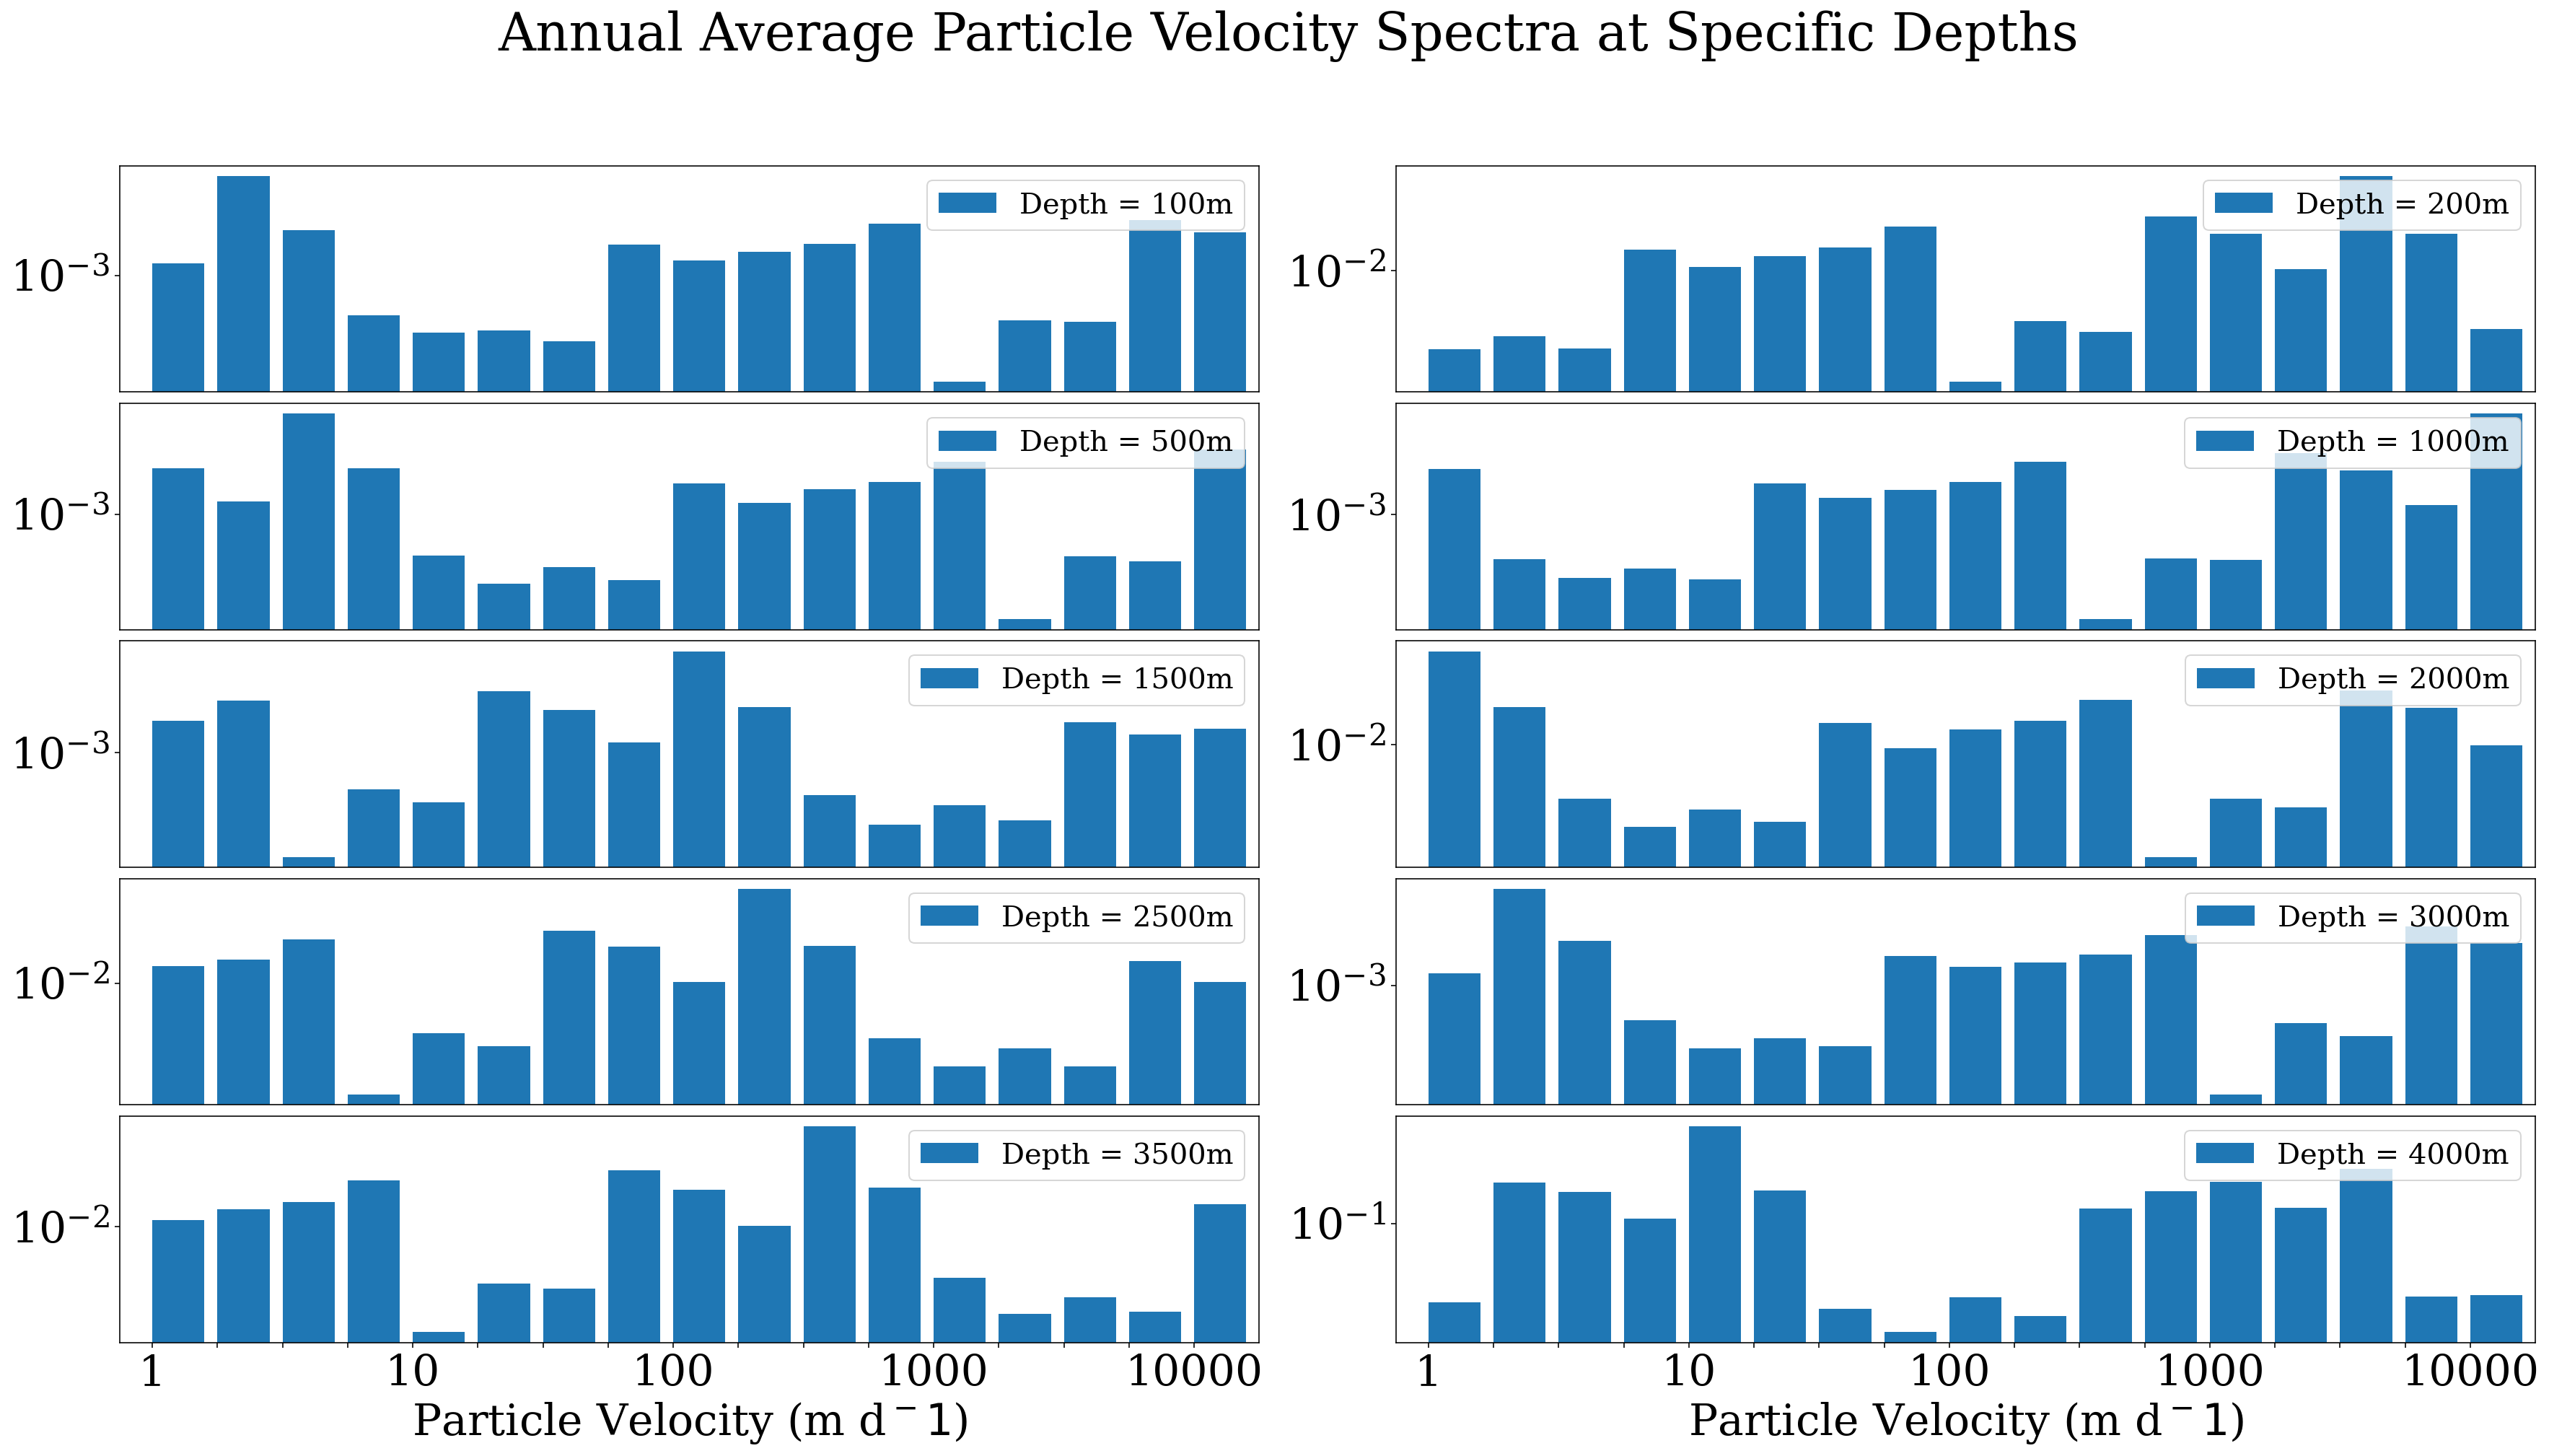

In [18]:
#seasonal average of particle velocity spectra 
array_of_depth = [100,200,500,1000,1500,2000,2500,3000,3500,4000]

#setting the plotting parameters
params = {
    'image.cmap': 'gray',
    'axes.labelsize': 30, # fontsize for x and y labels (was 10)
    'axes.titlesize': 30,
    'font.size': 30, # was 10
    'legend.fontsize': 20, # was 10
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'figure.figsize': [30, 15],
    'font.family': 'serif',
}

#updating parameters for plotting
matplotlib.rcParams.update(params)

#setting up the graph structure
fig = plt.figure()
fig.suptitle("Annual Average Particle Velocity Spectra at Specific Depths") 
gs = matplotlib.gridspec.GridSpec(5, 2, width_ratios=[1.,1.], height_ratios=[1.,1.,1.,1.,1.])
gs.update(wspace=0.12, hspace=0.05)

#calculating the seasonal average 
#loop through all depths
for j in range(len(array_of_depth)):
    #data of all veloclasses at one specific depth
    sep_depth_vel = avgparticleatt_veloclass_all[avgparticleatt_veloclass_all['depth_reached']
                                 == array_of_depth[j]][['#_of_particles','type','month','season']]
    #loop through all veloclasses
    for i in range(1,16):
        #we need to create one DataFrame for the first veloclass and then add on data for all other veloclasses
        if i == 1:
            #separating one particle veloclass
            one_type_on_sep_depth_vel = sep_depth_vel[sep_depth_vel['type'] == i][['#_of_particles','season']]
            #calculating the seasonal average
            one_type_one_depth_mean_vel = one_type_on_sep_depth_vel.groupby('season').mean().reset_index()
            #recording the velocity class
            one_type_one_depth_mean_vel['velo_class'] = i
            #recording the depth
            one_type_one_depth_mean_vel['depth'] = array_of_depth[j]
        else:
            # doing the same for every other velocity class
            other_one_type_on_sep_depth_vel = sep_depth_vel[sep_depth_vel['type'] ==
                                                            i][['#_of_particles','season']]
            other_one_type_one_depth_mean_vel = other_one_type_on_sep_depth_vel.groupby(
                'season').mean().reset_index()
            other_one_type_one_depth_mean_vel['velo_class'] = i
            other_one_type_one_depth_mean_vel['depth'] = array_of_depth[j]
            
            #combining the data for different velocity  classes together
            one_type_one_depth_mean_vel = pd.concat((one_type_one_depth_mean_vel,
                                                 other_one_type_one_depth_mean_vel)).reset_index(drop=True)
    #separating only the required features (columns)
    all_types_one_depth_vel = one_type_one_depth_mean_vel[['season','#_of_particles','velo_class','depth']]
    
    #calculating the annual average for every velocity class 
    annual_average_vel = sep_depth_vel[['type','#_of_particles']].groupby(by='type').mean().reset_index()


    #plotting the annual particle velocity distribution 
    ax1 = fig.add_subplot(gs[j])
    ax1.bar(annual_average_vel['type'], annual_average_vel['#_of_particles'],log=True,
            label='Depth = ' +str(array_of_depth[j]) +'m', align='edge')
    
    if j<=7: #drops all x labels for top subplots
        ax1.tick_params(top=False, bottom=False, labelleft='on', labelbottom=False)

    if j>7: # labeling the x axis on the bottom two subplots
        ax1.tick_params(bottom=True, labelleft='on', labelbottom=True)

        ax1.set_xticks(annual_average_vel['type'] )
        ax1.set_xticklabels(['1','','','','10','','','','100','','','','1000','','','','10000'])
        ax1.set_xlabel(r'Particle Velocity (m d$^-1$)')

        
    ax1.set_xlim(0.5,18)
    ax1.legend(loc='upper right')

#saving the figure
#plt.savefig("Annual_Average_Particle_Velocity_Spectra_at_Specific_Depth.png")   
plt.show()